In [46]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torch.nn import KLDivLoss
from torch.nn.functional import interpolate
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [47]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
# Interpolating to image size used in experiments
img_tensor = interpolate(img_tensor, size=(3, 128, 128))
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape
print(img_tensor.shape)

torch.Size([16, 4, 3, 128, 128])


In [48]:
patch_size = (7, 7)
hist_norm_p = float('inf')  # 0, 1, 2, float('inf')
v_min = 0.0
v_max = 1.0
n_bins = 100  # 100 / 250

In [49]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

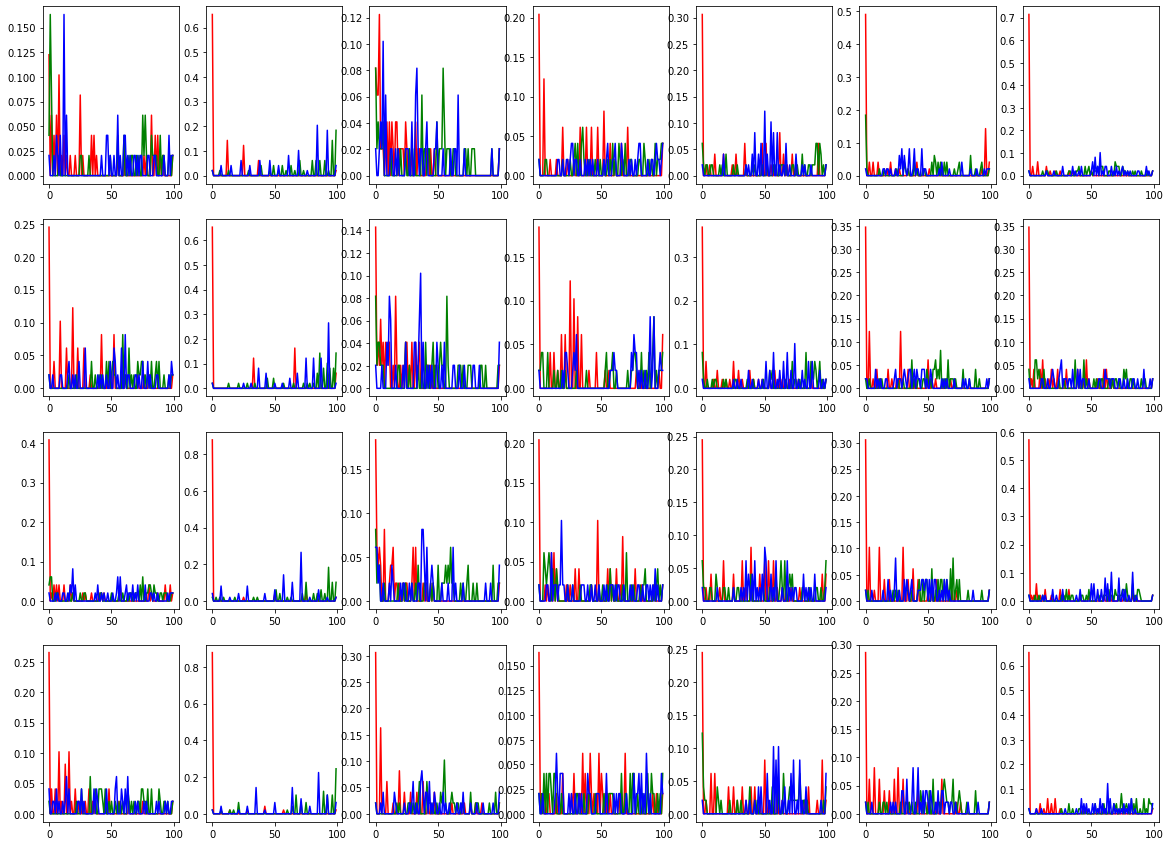

In [50]:
import numpy as np

perfect_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_hists[n, t, k, c] = torch.histc(perfect_kpt_patches[n, t, k, c], bins=n_bins)
                # Normalizing hists to probabilities 
                # (Each count devided by total number of counts)
                perfect_hists[n, t, k, c] /= torch.sum(perfect_hists[n, t, k, c])

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 2], color='blue')
    

tensor([[0.1633, 0.2653, 0.1020, 0.1224, 0.1224, 0.1633, 0.3673],
        [0.1633, 0.2653, 0.1020, 0.1020, 0.1224, 0.1224, 0.2245],
        [0.1429, 0.1837, 0.1224, 0.1020, 0.1020, 0.0816, 0.1020]])
tensor(0.1545)


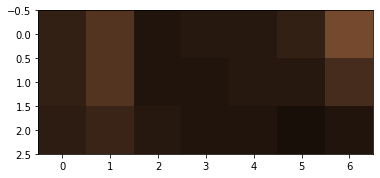

In [51]:
perfect_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_dist[k, t] = torch.norm(perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :])**2/\
            (perfect_hists[0, t:t+1, k, :] + perfect_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        perfect_dist[k, t] = torch.mean(d)
        """
        
print(perfect_dist.T)
        
plt.imshow(perfect_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(perfect_dist.mean())

In [52]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))


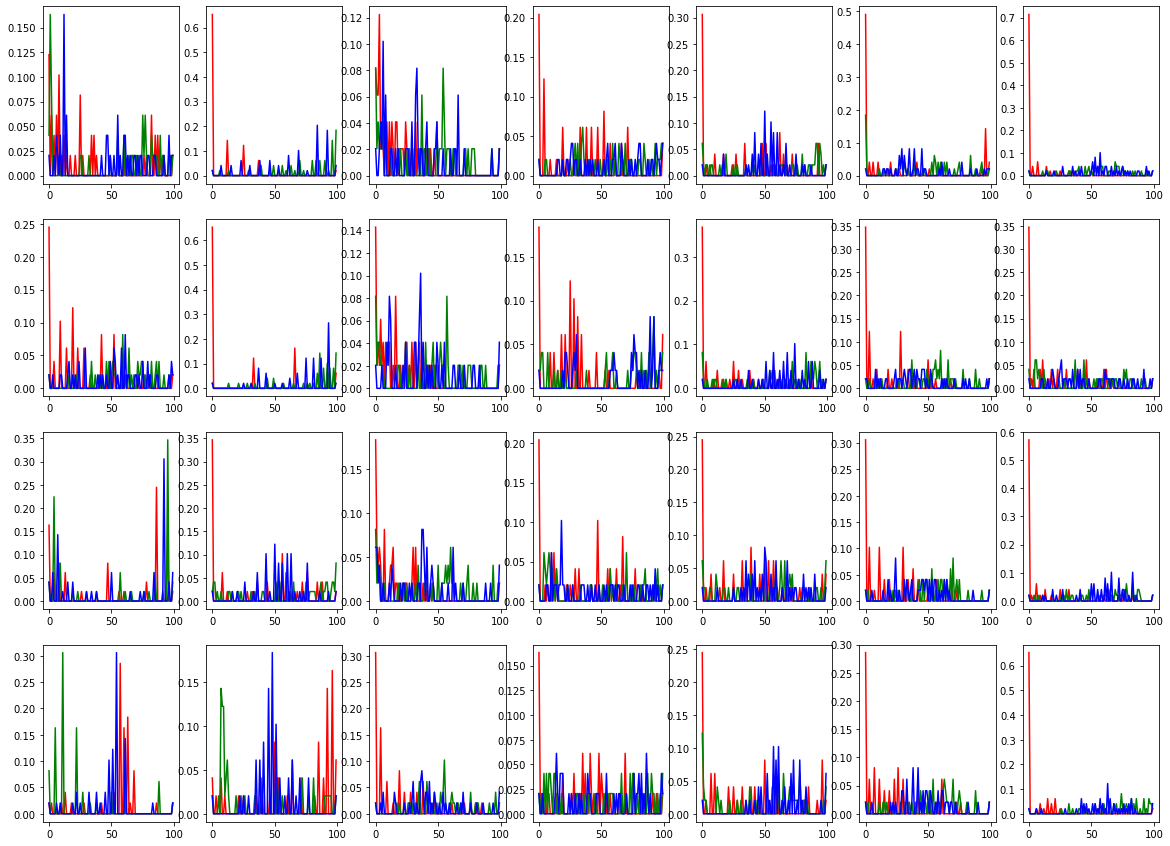

In [53]:
bad_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_hists[n, t, k, c] = torch.histc(bad_kpt_patches[n, t, k, c], bins=n_bins)
                bad_hists[n, t, k, c] /= torch.sum(bad_hists[n, t, k, c])

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 2], color='blue')

tensor([[0.1633, 0.2653, 0.1020, 0.1224, 0.1224, 0.1633, 0.3673],
        [0.3469, 0.3061, 0.1020, 0.1020, 0.1224, 0.1224, 0.2245],
        [0.3469, 0.3061, 0.1224, 0.1020, 0.1020, 0.0816, 0.1020]])
tensor(0.1808)


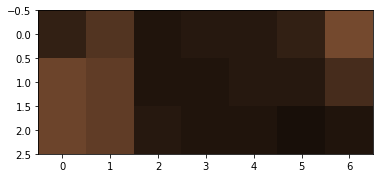

In [54]:
bad_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # bad_dist[k, t] = dkl(bad_hists[0, t:t+1, k, :], bad_hists[0, t+1:t+2, k, :])
        bad_dist[k, t] = torch.norm(bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :])**2/\
            (bad_hists[0, t:t+1, k, :] + bad_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        bad_dist[k, t] = torch.mean(d)
        """
        
print(bad_dist.T)
        
plt.imshow(bad_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(bad_dist.mean())

In [55]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

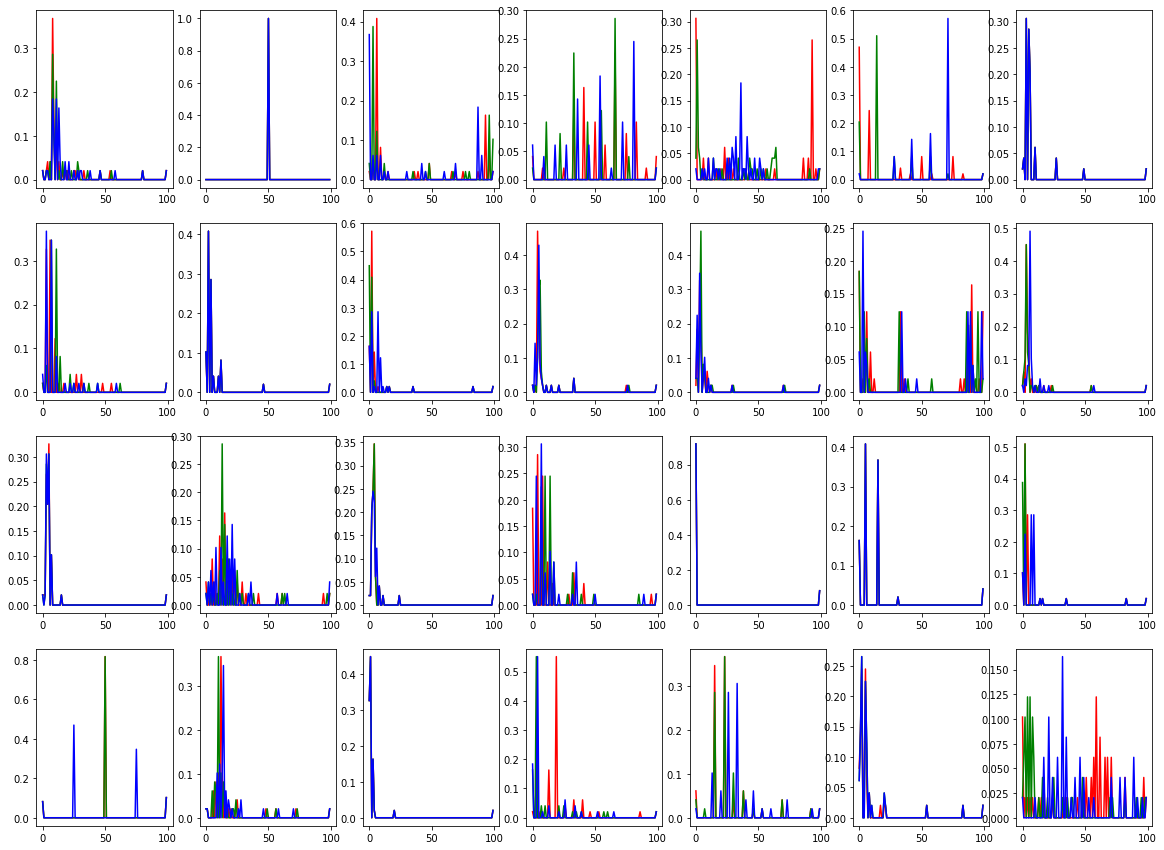

In [56]:
random_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_hists[n, t, k, c] = torch.histc(random_kpt_patches[n, t, k, c], bins=n_bins)
                random_hists[n, t, k, c] /= torch.sum(random_hists[n, t, k, c])

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 2], color='blue')

tensor([[0.3673, 1.0000, 0.5714, 0.4694, 0.4694, 0.5714, 0.2857],
        [0.3469, 0.4082, 0.4286, 0.4286, 0.8980, 0.4082, 0.5102],
        [0.8163, 0.3673, 0.4286, 0.5510, 0.8980, 0.3673, 0.4898]])
tensor(0.5277)


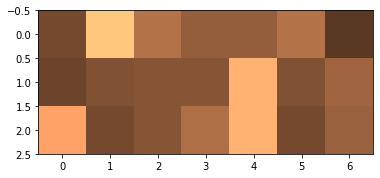

In [57]:
random_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # random_dist[k, t] = dkl(random_hists[0, t:t+1, k, :], random_hists[0, t+1:t+2, k, :])
        random_dist[k, t] = torch.norm(random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :])**2/\
            (random_hists[0, t:t+1, k, :] + random_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        random_dist[k, t] = torch.mean(d)
        """

print(random_dist.T)
        
plt.imshow(random_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(random_dist.mean())

Tensor based loss formulation

In [58]:
H_t_perfect = perfect_hists.unsqueeze(1) - perfect_hists.unsqueeze(2)
H_t_perfect = torch.norm(H_t_perfect, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_perfect = torch.sum(H_t_perfect, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_perfect))

tensor(0.1628)


In [59]:
H_t_bad = bad_hists.unsqueeze(1) - bad_hists.unsqueeze(2)
H_t_bad = torch.norm(H_t_bad, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_bad = torch.sum(H_t_bad, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_bad))

tensor(0.2036)


In [60]:
H_t_random = random_hists.unsqueeze(1) - random_hists.unsqueeze(2)
H_t_random = torch.norm(H_t_random, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_random = torch.sum(H_t_random, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_random))

tensor(0.5423)
